# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install seaborn
!python -m pip install scipy

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Loading Data and Subdividing into Smaller Batches

In [69]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
# creates an overlap of two months between subsets
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))

# x and y limits for the entire dataset to be used in plotting
x_min = df['x.pos.asec'].min()
x_max = df['x.pos.asec'].max()
y_min = df['y.pos.asec'].min()
y_max = df['y.pos.asec'].max()

(-1004, 996), (-974, 986)


# Intensity Estimation

## Method 1: Intensity Based on `total.counts`

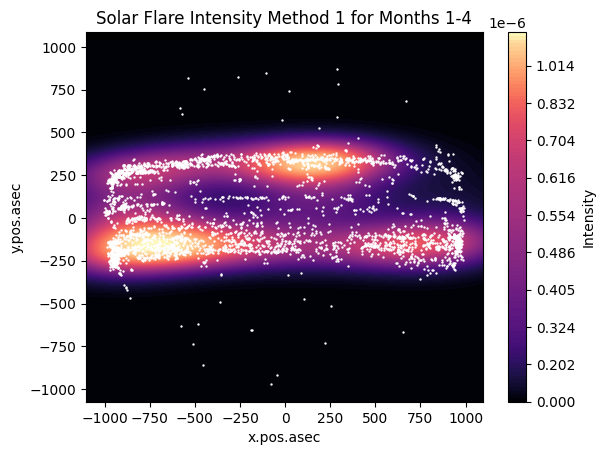

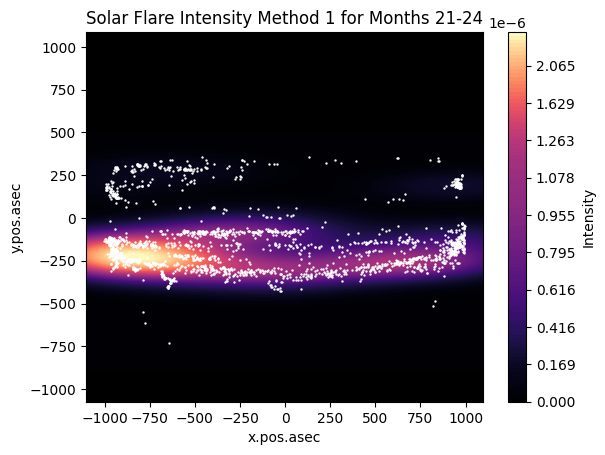

In [80]:
def intensity_estimation_frequency(data, plot=False, levels=10):
    # getting the x, y, and total.counts values in numpy arrays
    x = data['x.pos.asec'].values.flatten()
    y = data['y.pos.asec'].values.flatten()
    counts = data['total.counts'].values.flatten()
    
    if plot:
        # new matplotlib figure
        fig, ax = plt.subplots()

        # seaborn kde plot, uses scipy gaussian_kde underneath
        sns.kdeplot(data=data, x='x.pos.asec', y='y.pos.asec', 
                           weights='total.counts', fill=True, levels=levels, 
                           thresh=0, cmap='magma', cbar=True, ax=ax)
        
        # Setting the background color of the plot 
        # using set_facecolor() method
        ax.set_facecolor("black")

        # getting colorbar
        cb = ax.collections[-1].colorbar
        
        # color bar label
        cb.set_label('Intensity')

        # retrieving the tick values for the colorbar, can be used as threshold values 
        ticks = cb.get_ticks()

        # adjusting domain and range
        ax.set_xlim(x_min - 100, x_max + 100)
        ax.set_ylim(y_min - 100, y_max + 100)


        # plotting the scatterplot on top of the kde plot
        plt.scatter(x, y, s=0.5, facecolor='white')

        # title
        ax.set_title(f"Solar Flare Intensity Method 1 for Months {data['month'].min()}-{data['month'].max()}")
        
        # saving the figure to the output folder
        date_range = f"{data['year'].iloc[0]}_{data['month'].min()}-{data['month'].max()}"
        plt.savefig(f"./output/intensity_frequency_{date_range}.png")

        # return the values for the contours, which can serve as threshold values for hotspot analysis
        return ticks
    else:
        # data from the subset to be passed to gaussian kernel
        training_locations = np.vstack([x, y])

        # gaussian kernel, bandwidth using "scott's rule", using the total.counts attribute as weights
        kde = stats.gaussian_kde(training_locations, bw_method='scott', weights=counts.T)

        # returning the intensity values for each location
        return kde.evaluate(training_locations)
    
# performing the intesity estimation on months 1-4 and 21-24
s1 = dfs[0]
s2 = dfs[-1]

a = intensity_estimation_frequency(s1, plot=True, levels=100)
b = intensity_estimation_frequency(s2, plot=True, levels=100)

## Method 2: Intensity Based on `duration.s` and `energy.kev`

In [58]:
def map_and_normalize(data):
    # maps energy band to average energy
    energy_band_mapping = {    
        '6-12': 9,
        '12-25': 18.5,
        '25-50': 37.5,
        '50-100': 75,
        '100-300': 200,
        '300-800': 550,
        '800-7000': 3900,
        '7000-20000': 13500
    }

    # new column from mapping
    data['energy.median.kev'] = data['energy.kev'].map(energy_band_mapping)

    # retrieving max duration and max energy value
    max_duration = data['duration.s'].max()
    max_energy = data['energy.median.kev'].max()

    # normalizing columns
    data['normalized.duration'] = data['duration.s'] / max_duration
    data['normalized.energy'] = data['energy.median.kev'] / max_energy

    # calculating intensity based on duration * average energy of band
    data['intensity.method.2'] = data['normalized.duration'] * data['normalized.energy']

    # returning the modified data frame
    return data

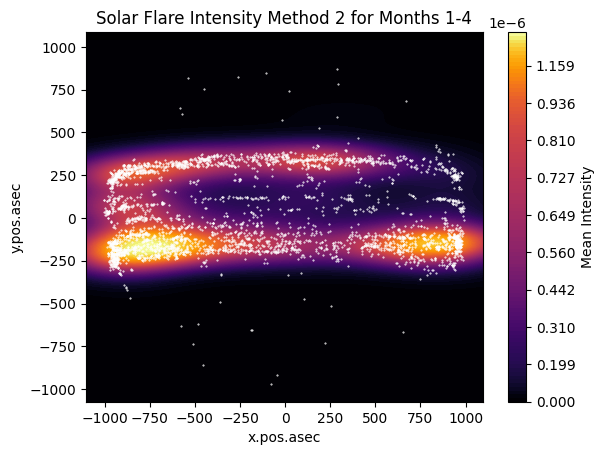

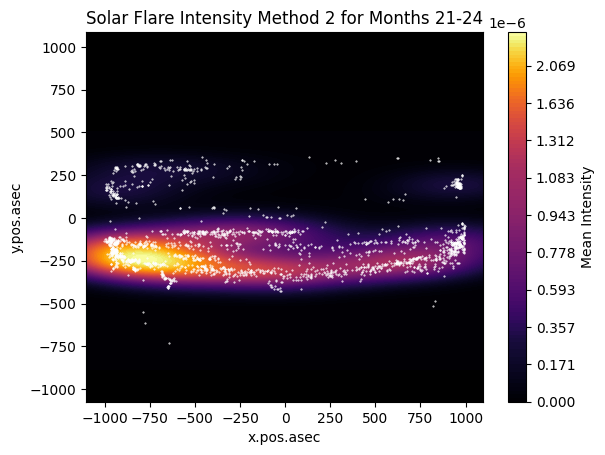

In [91]:
def intensity_estimation_energy(data, plot=False, gridsize=40):
    # energy-based intensity data
    intensity = data['intensity.method.2'].values.flatten()
    # x and y values
    x = data['x.pos.asec'].values.flatten()
    y = data['y.pos.asec'].values.flatten()

    if plot:
        # new matplotlib figure
        fig, ax = plt.subplots()
        
        # seaborn kde plot, uses scipy gaussian_kde underneath
        ax = sns.kdeplot(data=data, x='x.pos.asec', y='y.pos.asec', 
                           weights='intensity.method.2', fill=True, levels=100, 
                           thresh=0, cmap='inferno', cbar=True, bw_method='scott')

        # Setting the background color of the plot 
        # using set_facecolor() method
        ax.set_facecolor("black")

        # adjusting domain and range
        plt.xlim(x_min - 100, x_max + 100)
        plt.ylim(y_min - 100, y_max + 100)

        # color bar and label
        cb = ax.collections[-1].colorbar
        cb.set_label('Mean Intensity')

        # plotting the scatterplot on top of the kde plot
        plt.scatter(x, y, s=0.2, facecolor='white')

        ax.set_title(f"Solar Flare Intensity Method 2 for Months {data['month'].min()}-{data['month'].max()}")
        date_range = f"{data['year'].iloc[0]}_{data['month'].min()}-{data['month'].max()}"
        plt.savefig(f"./output/intensity_energy_{date_range}.png")
        plt.show()

        return fig, ax
    else:
        return intensity

# plotting for months 1-4 and 21-24
s1 = map_and_normalize(dfs[0])
s2 = map_and_normalize(dfs[-1])

a, b = intensity_estimation_energy(s1, plot=True, gridsize=20)
c, d = intensity_estimation_energy(s2, plot=True, gridsize=20)